# Using HUtil with the Digital Earth Hackathon Catalog

This notebook demonstrates how to use the `hutil` package with the Digital Earth Hackathon catalog. We'll show how to load data from the catalog and use both direct function calls and the xarray accessor to perform selection operations on HEALPix data.

## Setup

First, let's import the necessary packages and load the catalog.

In [1]:
import intake
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings

# Import hutil
import hutil
from hutil import selection

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Load the Digital Earth Hackathon Catalog

The Digital Earth Hackathon provides a catalog of datasets that we can access. Let's load the catalog and see what datasets are available.

In [2]:
# Load the catalog
print("Loading the Digital Earth Hackathon catalog...")
current_location = "online"
cat = intake.open_catalog("https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml")[current_location]

# List available datasets
print("\nAvailable datasets in the catalog:")
list(cat)

Loading the Digital Earth Hackathon catalog...

Available datasets in the catalog:


['CERES_EBAF',
 'ERA5',
 'IR_IMERG',
 'JRA3Q',
 'MERRA2',
 'arp-gem-1p3km',
 'arp-gem-2p6km',
 'casesm2_10km_nocumulus',
 'icon_d3hp003',
 'icon_d3hp003aug',
 'icon_d3hp003feb',
 'icon_ngc4008',
 'ifs_tco3999-ng5_deepoff',
 'ifs_tco3999-ng5_rcbmf',
 'ifs_tco3999-ng5_rcbmf_cf',
 'ifs_tco3999_rcbmf',
 'nicam_220m_test',
 'nicam_gl11',
 'scream-dkrz',
 'tracking-d3hp003',
 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest',
 'um_glm_n1280_CoMA9_TBv1p2',
 'um_glm_n1280_GAL9',
 'um_glm_n2560_RAL3p3']

Let's examine the parameters available for one of the datasets (ICON model).

In [3]:
import pandas as pd

# Examine the parameters for the ICON model dataset
pd.DataFrame(cat["icon_d3hp003"].describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT1H, PT3H, PT6H, P1D]",P1D
1,time_method,time subsetting method,str,"[mean, inst]",mean
2,zoom,zoom resolution of the dataset,int,"[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


## Load a Dataset from the Catalog

Now let's load a dataset from the catalog. We'll use the ICON model dataset with zoom level 7 (approximately 50km resolution).

In [4]:
# Select a dataset (ICON model)
dataset_name = "icon_d3hp003"
print(f"Loading {dataset_name} dataset with zoom level 7 (approx. 50km resolution)...")

# Load the dataset with zoom level 7 (approx. 50km resolution)
ds = cat[dataset_name](zoom=7).to_dask()

# Print dataset information
print(f"\nDataset information:")
print(f"  - Dimensions: {dict(ds.dims)}")
print(f"  - Variables: {list(ds.data_vars)}")
print(f"  - Time range: {ds.time.values[0]} to {ds.time.values[-1]}")

ds

Loading icon_d3hp003 dataset with zoom level 7 (approx. 50km resolution)...

Dataset information:
  - Dimensions: {'time': 425, 'cell': 196608, 'crs': 1, 'pressure': 30, 'soil_level': 5, 'pressure_rva': 3}
  - Variables: ['clivi', 'clt', 'clwvi', 'egpvi', 'einvi', 'ekhvi', 'ekvvi', 'hflsd', 'hfssd', 'hur', 'hus', 'huss', 'mrso', 'o3vi', 'orog', 'pr', 'prs', 'prw', 'ps', 'psl', 'qall', 'rlds', 'rldscs', 'rlus', 'rlut', 'rlutcs', 'rsds', 'rsdscs', 'rsdt', 'rsus', 'rsuscs', 'rsut', 'rsutcs', 'rva', 'sftgif', 'sftlf', 'siconc', 'sncvfa', 'swe', 'ta', 'tas', 'tauu', 'tauv', 'tend_egpdynvi', 'tend_eincldvi', 'tend_eindynvi', 'tend_einradvi', 'tend_eintmxvi', 'tend_ekhdynvi', 'tend_ekhtmxvi', 'tend_ekvdynvi', 'ts', 'ua', 'uas', 'va', 'vas', 'wa', 'zg']
  - Time range: 2020-01-02T00:00:00.000000000 to 2021-03-01T00:00:00.000000000


<xarray.Dataset> Size: 98GB
Dimensions:        (time: 425, cell: 196608, crs: 1, pressure: 30,
                    soil_level: 5, pressure_rva: 3)
Coordinates:
  * crs            (crs) float32 4B nan
  * pressure       (pressure) int64 240B 5 10 20 50 ... 92500 95000 97500 100000
  * pressure_rva   (pressure_rva) int64 24B 16 18 23
  * soil_level     (soil_level) int64 40B 0 0 0 2 6
  * time           (time) datetime64[ns] 3kB 2020-01-02 ... 2021-03-01
Dimensions without coordinates: cell
Data variables: (12/58)
    clivi          (time, cell) float32 334MB ...
    clt            (time, cell) float32 334MB ...
    clwvi          (time, cell) float32 334MB ...
    egpvi          (time, cell) float32 334MB ...
    einvi          (time, cell) float32 334MB ...
    ekhvi          (time, cell) float32 334MB ...
    ...             ...
    ua             (time, pressure, cell) float32 10GB ...
    uas            (time, cell) float32 334MB ...
    va             (time, pressure, cell) float32 10GB ...
    vas            (time, cell) float32 334MB ...
    wa             (time, pressure, cell) float32 10GB ...
    zg             (time, pressure, cell) float32 10GB ...

Let's select a variable and time step to work with.

In [5]:
# Select a variable and time step
var_name = "ts"  # Surface temperature
time_idx = 0  # First time step

print(f"Selecting variable '{var_name}' at time {ds.time.values[time_idx]}...")
da = ds[var_name].isel(time=time_idx)

da

Selecting variable 'ts' at time 2020-01-02T00:00:00.000000000...


<xarray.DataArray 'ts' (cell: 196608)> Size: 786kB
[196608 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-01-02
Dimensions without coordinates: cell
Attributes:
    grid_mapping:        crs
    hiopy::enable:       True
    hiopy::nnn:          4
    hiopy::time_method:  mean
    long_name:           surface temperature
    short_name:          
    standard_name:       surface_temperature
    units:               K

In [14]:
# Select a variable and time step
var_name = "ta"  # Surface temperature
time_idx = 0  # First time step

print(f"Selecting variable '{var_name}' at time {ds.time.values[time_idx]}...")
dta = ds[var_name].isel(time=time_idx)

dta

Selecting variable 'ta' at time 2020-01-02T00:00:00.000000000...


<xarray.DataArray 'ta' (pressure: 30, cell: 196608)> Size: 24MB
[5898240 values with dtype=float32]
Coordinates:
  * pressure  (pressure) int64 240B 5 10 20 50 100 ... 92500 95000 97500 100000
    time      datetime64[ns] 8B 2020-01-02
Dimensions without coordinates: cell
Attributes:
    grid_mapping:        crs
    hiopy::enable:       True
    hiopy::nnn:          4
    hiopy::src_name:     pl::temp
    hiopy::time_method:  mean
    long_name:           Temperature
    short_name:          
    standard_name:       air_temperature
    units:               K

In [7]:
sat_trac= xr.open_dataset("/home/suvarchal/Downloads/EC_CPR_orbit/ECA_J_CPR_NOM_1BS_20240617T2053_20240617T2105_00311B_vAb_location.nc")

In [8]:
sat_trac

<xarray.Dataset> Size: 159kB
Dimensions:  (ray: 9962)
Dimensions without coordinates: ray
Data variables:
    lon      (ray) float64 80kB ...
    lat      (ray) float64 80kB ...

In [11]:
latlon=[(lon,lat) for lon,lat in zip(sat_trac.lon.values,sat_trac.lat.values)]

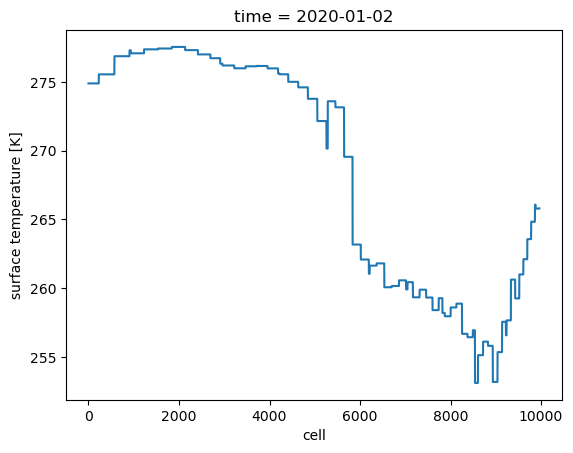

In [13]:
da.hutil.select_at_points(latlon).plot()

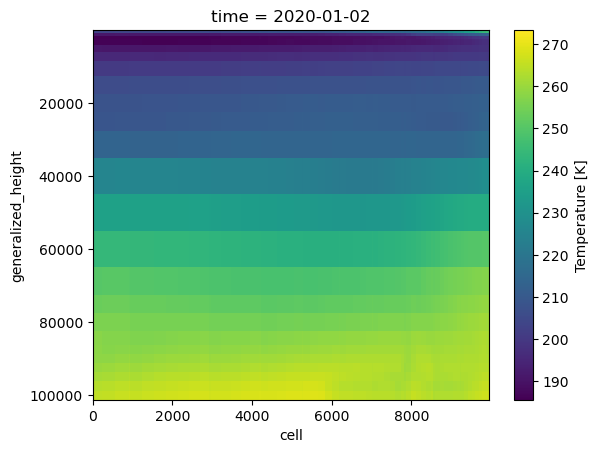

In [16]:
dta.hutil.select_at_points(latlon).plot(yincrease=False)

## Method 1: Using Direct Function Calls

First, let's demonstrate how to use the hutil functions directly.

In [6]:
# Get HEALPix information from the dataset
nside, nest, npix = selection.get_healpix_info(da)
print(f'HEALPix info: nside={nside}, nest={nest}, npix={npix}')

HEALPix info: nside=128, nest=True, npix=196608


In [7]:
# Add latitude and longitude coordinates to the dataset
da_with_latlon = selection.add_latlon_coords(da)
print('Added lat/lon coordinates to dataset')

da_with_latlon

Added lat/lon coordinates to dataset


<xarray.Dataset> Size: 4MB
Dimensions:  (cell: 196608)
Coordinates:
    time     datetime64[ns] 8B 2020-01-02
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... -44.65 -45.35 -45.0
Dimensions without coordinates: cell
Data variables:
    ts       (cell) float32 786kB ...

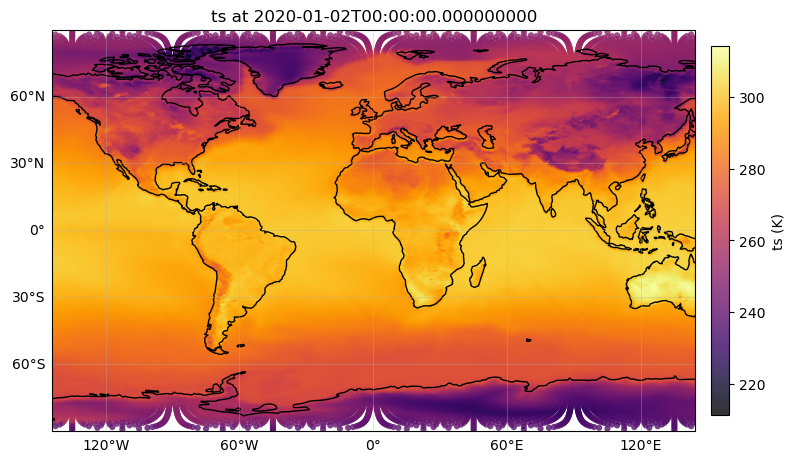

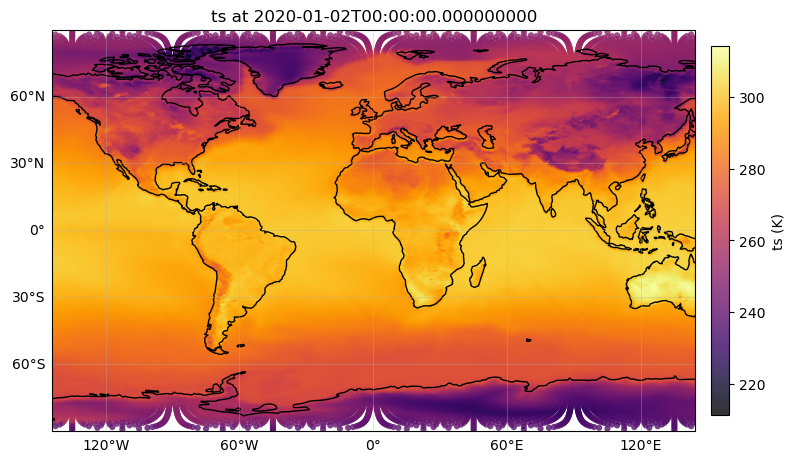

In [8]:
# Plot the original dataset
selection.plot_healpix_selection(da_with_latlon, 
                                title=f"{var_name} at {ds.time.values[time_idx]}", 
                                cmap="inferno")

### Selecting Data at a Specific Latitude

Let's select data along the equator (latitude = 0u00b0).

Selected 6656 points at the equator


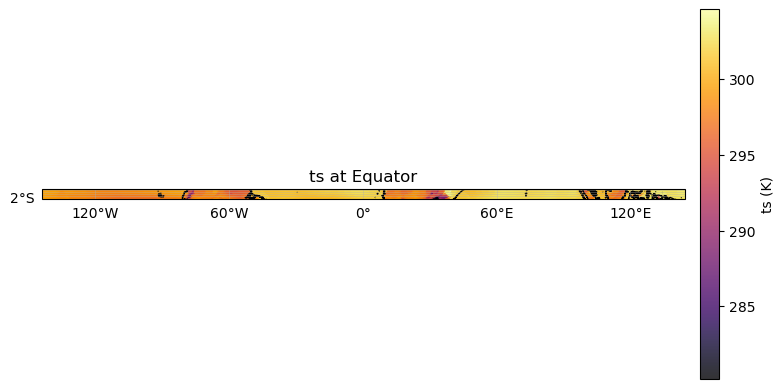

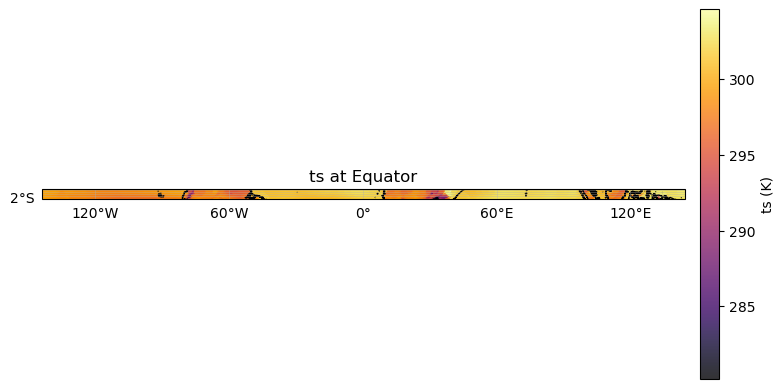

In [9]:
# Select data at the equator (latitude = 0u00b0)
equator_data = selection.select_at_latitude(da_with_latlon, latitude=0, tolerance=2.0)
print(f'Selected {len(equator_data.cell)} points at the equator')

# Plot the selected data
selection.plot_healpix_selection(equator_data, 
                                title=f"{var_name} at Equator", 
                                cmap="inferno")

### Selecting Data in a Region

Let's select data within the Africa region.

Selecting data in the Africa region...
Selected 23536 points in the Africa region


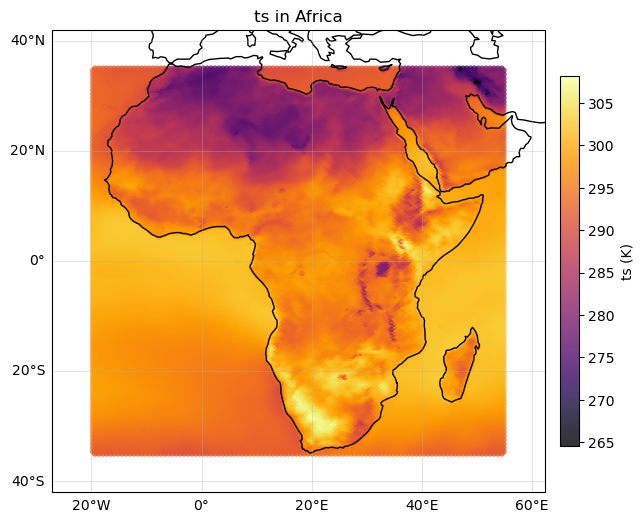

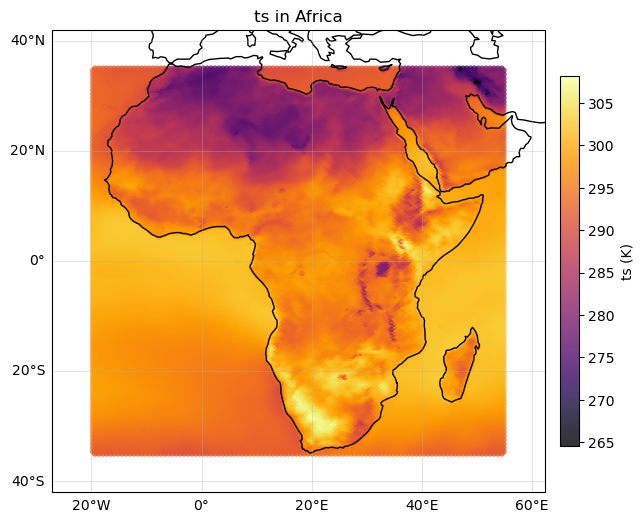

In [10]:
# Select a region (Africa)
print("Selecting data in the Africa region...")
africa_data = selection.select_region(
    da_with_latlon,
    lat_min=-35, lat_max=35,
    lon_min=-20, lon_max=55
)
print(f"Selected {len(africa_data.cell)} points in the Africa region")

# Plot the selected data
selection.plot_healpix_selection(africa_data, 
                                title=f"{var_name} in Africa", 
                                cmap="inferno")

## Method 2: Using the xarray Accessor

Now let's demonstrate how to use the hutil accessor with xarray datasets.

In [11]:
# Get HEALPix information using the accessor
nside, nest, npix = da.hutil.get_info()
print(f'HEALPix info: nside={nside}, nest={nest}, npix={npix}')

HEALPix info: nside=128, nest=True, npix=196608


In [12]:
# Add latitude and longitude coordinates using the accessor
da_accessor = da.hutil.add_latlon_coords()
print('Added lat/lon coordinates to dataset using accessor')

da_accessor

Added lat/lon coordinates to dataset using accessor


<xarray.DataArray 'ts' (cell: 196608)> Size: 786kB
[196608 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 8B 2020-01-02
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... -44.65 -45.35 -45.0
Dimensions without coordinates: cell
Attributes:
    grid_mapping:        crs
    hiopy::enable:       True
    hiopy::nnn:          4
    hiopy::time_method:  mean
    long_name:           surface temperature
    short_name:          
    standard_name:       surface_temperature
    units:               K

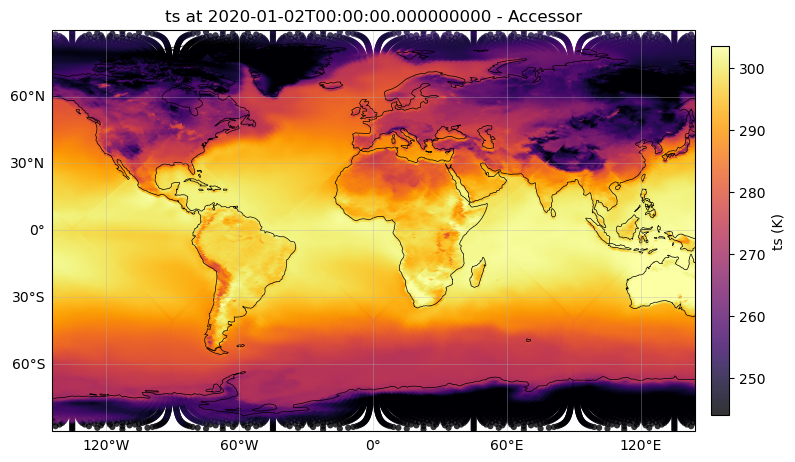

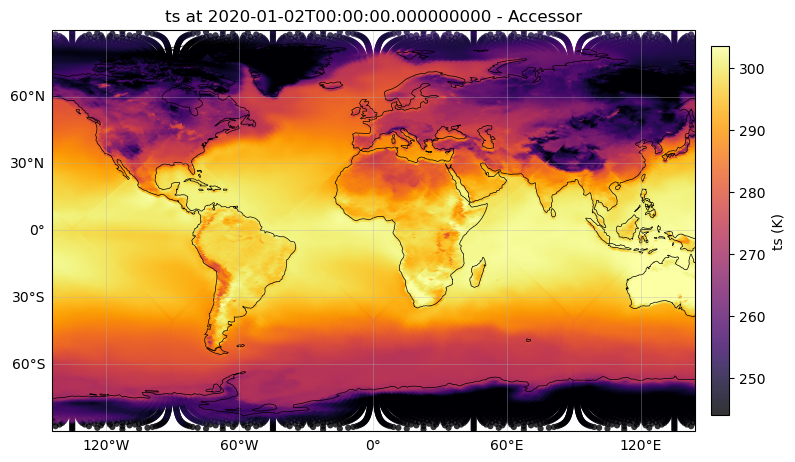

In [13]:
# Plot the dataset using the accessor
da_accessor.hutil.plot(title=f"{var_name} at {ds.time.values[time_idx]} - Accessor", cmap="inferno")

### Selecting Data at a Specific Latitude

Let's select data along the equator using the accessor.

Selected 6656 points at the equator using accessor


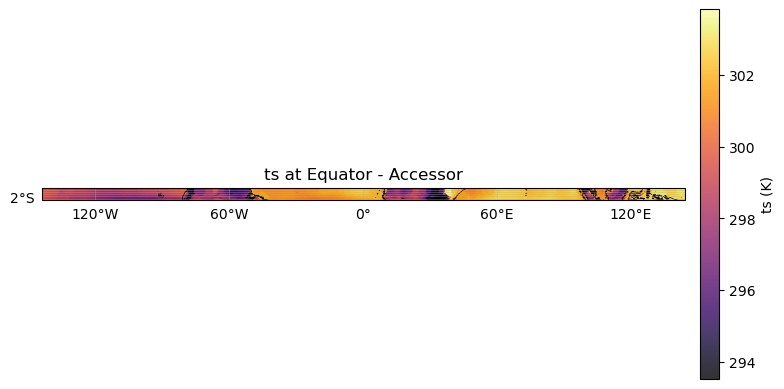

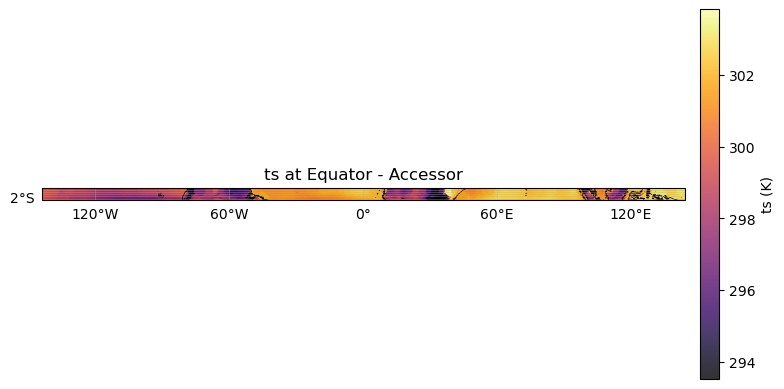

In [14]:
# Select data at the equator using the accessor
equator_data_accessor = da_accessor.hutil.select_at_latitude(latitude=0, tolerance=2.0)
print(f'Selected {len(equator_data_accessor.cell)} points at the equator using accessor')

# Plot the selected data using the accessor
equator_data_accessor.hutil.plot(title=f"{var_name} at Equator - Accessor", cmap="inferno")

### Selecting Data in a Region

Let's select data within the South America region using the accessor.

Selecting data in the South America region using accessor...
Selected 16123 points in the South America region


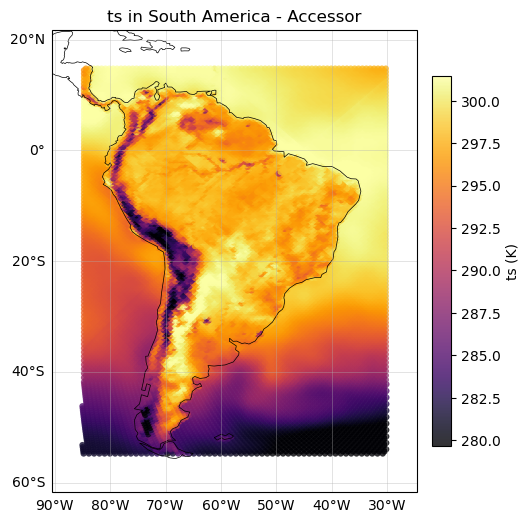

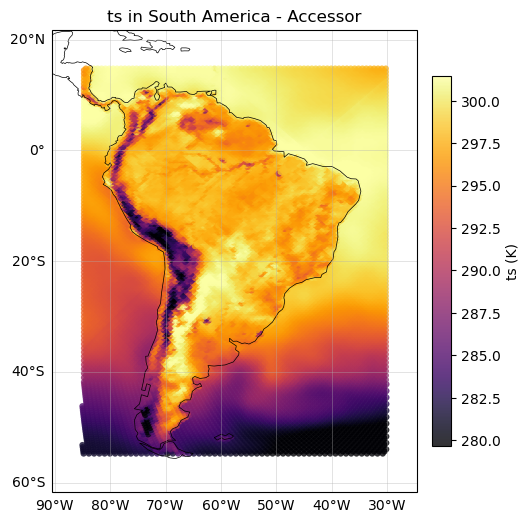

In [15]:
# Select a region (South America) using the accessor
print("Selecting data in the South America region using accessor...")
sam_data = da_accessor.hutil.select_region(
    lat_min=-55, lat_max=15,
    lon_min=-85, lon_max=-30
)
print(f"Selected {len(sam_data.cell)} points in the South America region")

# Plot the selected data using the accessor
sam_data.hutil.plot(title=f"{var_name} in South America - Accessor", cmap="inferno")

### Interpolating to a Regular Grid

Let's interpolate the HEALPix data to a regular lat/lon grid using the accessor.

Interpolating to a regular grid...


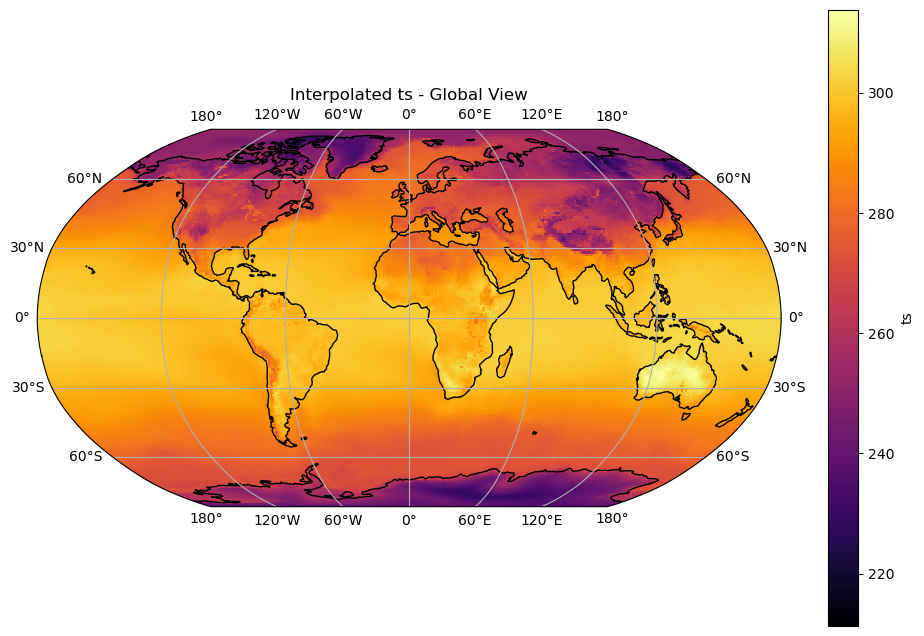

In [16]:
# Interpolate to a regular grid
print("Interpolating to a regular grid...")
grid_data = da_accessor.hutil.interpolate_to_grid(
    lat_res=1.0, lon_res=1.0,
    lat_min=-90, lat_max=90, lon_min=-180, lon_max=180,
    method="nearest"
)

# Plot the interpolated data
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.Robinson())
grid_data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap="inferno")
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.title(f"Interpolated {var_name} - Global View")
plt.show()

## Comparing Results

Let's verify that both methods (direct function calls and accessor) give the same results.

In [17]:
# Compare the results of both methods for equator selection
equator_direct = selection.select_at_latitude(da_with_latlon, latitude=0, tolerance=2.0)
equator_accessor = da_accessor.hutil.select_at_latitude(latitude=0, tolerance=2.0)

identical = np.array_equal(equator_direct.cell.values, equator_accessor.cell.values)
print(f"Results are identical: {identical}")

Results are identical: True


## Conclusion

This notebook has demonstrated how to use the `hutil` package with the Digital Earth Hackathon catalog. We've shown how to load data from the catalog and use both direct function calls and the xarray accessor to perform selection operations on HEALPix data.

The `hutil` package provides a convenient way to work with HEALPix datasets, making it easy to select data at specific latitudes, longitudes, or within regions, and to interpolate to regular grids. The xarray accessor provides a more intuitive interface for these operations, allowing you to chain methods directly on xarray objects.